## This is a FSI problem of 1-D flate plate falling in quiscent flow.

In [34]:
using Pkg
Pkg.activate("..")
using FSI

In [35]:
using Revise
using BSON: @save, @load

using Plots
pyplot()
clibrary(:colorcet)

default(grid = false)

In [36]:
filename = "FallingPlate";

## <span style="color:blue"> Set up rigid body with Dyn3d

#### Include any joint-body setup script from Dyn3d

In [67]:
# problem dimension
ndim = 2
# numerical params
tf = 6
dt = 1e-3
scheme = "Liska"
st = 3
tol = 1e-4
num_params = NumParams(tf, dt, scheme, st, tol)
# gravity
gravity = [0., -1.0, 0.]

# set up system config info
config_system = ConfigSystem(ndim, gravity, num_params)

# set up bodys
nbody = 1
config_body = ConfigBody(nbody, 4,
   [0. 0.; 1. 0.; 1. 1.0/nbody; 0. 1.0/nbody], 2.0)
config_bodys = fill(config_body, nbody)

# set up joints
njoint = nbody

config_joints = Vector{ConfigJoint}(undef,njoint)

# set the first passive joint with no stiff and damp
dof_1 = Dof(5, "passive", 0., 0., Motions())

config_joints[1] = ConfigJoint(njoint, "custom_prismatic_in_y",
    [0.,0.,0.,0.5,4.5,0.], zeros(Float64,6), 0, [dof_1], [0.])

 joint type = custom_prismatic_in_y
 joint position in parent body coord = [0.0, 0.0, 0.0, 0.5, 4.5, 0.0]
 joint position in child body coord = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 joint unconstrained dof = 5, under passive motion
 initial unconstrained dof position = [0.0]


#### Build joint-body chain

In [68]:
bs, js, bsys = BuildChain(config_bodys, config_joints, config_system)
bd = BodyDyn(bs, js, bsys)

This is a 1 body-joint system, system is un-mounted from space

#### Initialize rigid body system state to complete body-joint information

In [69]:
bd, soln₀ = InitSystem!(bd);

#### Initialize u and λ container

In [70]:
qJ = soln₀.qJ
v = soln₀.v
λ_dim = bd.sys.ncdof_HERK
λ = zeros(Float64,λ_dim);

#### Get body verts for plotting

In [71]:
@get bd (bs, js, sys)
bs, js, sys = UpdatePosition!(bs, js, sys, soln₀.qJ)
vs₀ = VertsHistory(sys.nbody, bs);

#### Plot body only

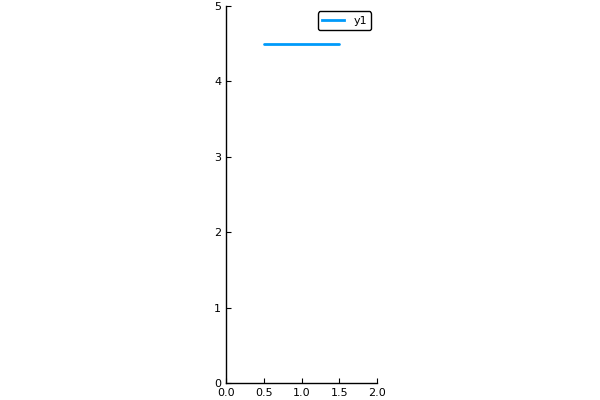

In [72]:
p = plot()
for i = 1:sys.nbody
    plot!(p,vs₀[i,2:3,1], vs₀[i,2:3,2],linewidth=2)
end
plot!(xlims=(0,2), ylims=(0,5),ratio=1)

## <span style="color:blue"> Set up fluid with Whirl </span>

#### Set the flow parameters

In [73]:
Re = 200 # Reynolds number
U = 0.0 # Free stream velocity
U∞ = (0.0, U)

(0.0, 0.0)

#### Set the domain grid

In [74]:
102*252

25704

In [75]:
nx = 102; ny = 252;
Ly = 5.0;
Δx = Ly/(ny-2);

Δt = min(0.5*Δx,0.5*Δx^2*Re)

w₀ = Nodes(Dual,(nx,ny))
xg, yg = coordinates(w₀,dx=Δx)

(-0.01:0.02:2.0100000000000002, -0.01:0.02:5.01)

#### Set up fluid initial conditions

In [76]:
w₀ .= 0.0;
w = deepcopy(w₀);

## <span style="color:blue"> Create fluid-body interface </span>

#### Body in fluid plane

In [77]:
plane = [1,2];

#### Genrate body grid points and get linear velocity on them

In [78]:
bgs = GenerateBodyGrid(bd; np=DetermineNP(nbody, Δx))
bgs = CutOut2d(bd,bgs);

#### Get body points initial coordinates for fluids

In [79]:
bgs = AcquireBodyGridKinematics(bd,bgs);

#### Set up body grid points and force container in fluid

In [80]:
X̃ = BodyGridToVectorData(bgs,"coord";plane=plane)
f = VectorData(X̃);

#### Create fluidstruct structure

In [81]:
tf = 450Δt
T = Δt:Δt:tf
fsys = FluidStruct((nx,ny),Re,Δx,Δt,U∞ = U∞, X̃ = X̃, rk=RK31)
N = length(X̃)÷2

51

## <span style="color:blue"> Create ifherk object </span>

#### pretend that this thin body has finite volume for buoyancy

In [82]:
@time ifherk_coupled = IFHERK_coupled(fsys.Δt,bd,bgs,(w₀,qJ,v,f,λ),
                ((t,u) -> Systems.plan_intfact(t,u,fsys), B₁ᵀ, B₂),
                (M, G₁ᵀ, G₂, UpP, UpV),
                ((bd,bgs,f) -> T₁ᵀ(bd,bgs,f,fsys.Δx;plane=plane),
                 (bd,bgs,u) -> T₂(bd,bgs,u;plane=plane),
                 (bd,bgs) -> getX̃(bd,bgs;plane=plane)),
                ((w,t) -> FSI.r₁(w,t,fsys), F, w -> U_inf(w,fsys), gti),
                fsys, tol=1e-3,rk=TimeMarching.RK31)

  2.016528 seconds (6.85 M allocations: 670.930 MiB, 9.85% gc time)


Stage-3+ IF-HERK integrator with
   Time step size 0.01


In [83]:
fx = Float64[]
fy = Float64[]
thist = []
t = 0.0
whist = []
bdhist = BodyDyn[];

## <span style="color:blue"> TimeMarching! </span>

In [84]:
@time for ti in T
    
    @time global t, (w, f), (qJ, v, λ), bd = ifherk_coupled(t, w, qJ, v, bd,fsys)
    
    push!(thist,t-Δt)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    push!(whist,deepcopy(w))
    push!(bdhist,deepcopy(bd))
    println("next time unit is $(round(t,digits=3))")
    
    if mod(round(Int,ti/Δt),200) == 1  
        @save filename*".bson" bd bdhist xg yg whist thist fx fy Δt w qJ v
        println("data saved at time ", ti)
    end
end

  2.438082 seconds (6.67 M allocations: 673.252 MiB, 4.10% gc time)
next time unit is 0.01
data saved at time 0.01
  1.207858 seconds (4.05 M allocations: 574.444 MiB, 5.93% gc time)
next time unit is 0.02
  1.208087 seconds (4.05 M allocations: 574.691 MiB, 5.94% gc time)
next time unit is 0.03
  1.277688 seconds (4.05 M allocations: 574.935 MiB, 5.51% gc time)
next time unit is 0.04
  1.147539 seconds (4.05 M allocations: 574.938 MiB, 5.75% gc time)
next time unit is 0.05
  1.133123 seconds (4.05 M allocations: 575.029 MiB, 5.81% gc time)
next time unit is 0.06
  1.175428 seconds (4.05 M allocations: 575.003 MiB, 5.58% gc time)
next time unit is 0.07
  1.140627 seconds (4.05 M allocations: 574.912 MiB, 5.98% gc time)
next time unit is 0.08
  1.127846 seconds (4.05 M allocations: 575.029 MiB, 5.78% gc time)
next time unit is 0.09
  1.157514 seconds (4.05 M allocations: 575.012 MiB, 5.73% gc time)
next time unit is 0.1
  1.136409 seconds (4.05 M allocations: 574.919 MiB, 5.80% gc time)

  1.151028 seconds (4.05 M allocations: 574.847 MiB, 5.58% gc time)
next time unit is 0.91
  1.126051 seconds (4.05 M allocations: 575.029 MiB, 5.67% gc time)
next time unit is 0.92
  1.164801 seconds (4.05 M allocations: 574.847 MiB, 5.67% gc time)
next time unit is 0.93
  1.136559 seconds (4.05 M allocations: 575.029 MiB, 5.98% gc time)
next time unit is 0.94
  1.146506 seconds (4.05 M allocations: 574.938 MiB, 5.49% gc time)
next time unit is 0.95
  1.182961 seconds (4.05 M allocations: 574.938 MiB, 5.45% gc time)
next time unit is 0.96
  1.135644 seconds (4.05 M allocations: 575.029 MiB, 5.60% gc time)
next time unit is 0.97
  1.168363 seconds (4.05 M allocations: 574.938 MiB, 5.74% gc time)
next time unit is 0.98
  1.176401 seconds (4.05 M allocations: 575.028 MiB, 5.82% gc time)
next time unit is 0.99
  1.134791 seconds (4.05 M allocations: 574.937 MiB, 5.67% gc time)
next time unit is 1.0
  1.112562 seconds (4.05 M allocations: 575.026 MiB, 5.79% gc time)
next time unit is 1.01


  1.119329 seconds (4.05 M allocations: 574.938 MiB, 5.71% gc time)
next time unit is 1.82
  1.202389 seconds (4.05 M allocations: 575.029 MiB, 5.51% gc time)
next time unit is 1.83
  1.451536 seconds (4.05 M allocations: 574.938 MiB, 5.68% gc time)
next time unit is 1.84
  1.294008 seconds (4.05 M allocations: 575.029 MiB, 5.52% gc time)
next time unit is 1.85
  1.274916 seconds (4.05 M allocations: 574.938 MiB, 5.71% gc time)
next time unit is 1.86
  1.250384 seconds (4.05 M allocations: 575.029 MiB, 5.58% gc time)
next time unit is 1.87
  1.269791 seconds (4.05 M allocations: 574.938 MiB, 5.71% gc time)
next time unit is 1.88
  1.267345 seconds (4.05 M allocations: 575.029 MiB, 5.80% gc time)
next time unit is 1.89
  1.210824 seconds (4.05 M allocations: 574.938 MiB, 5.93% gc time)
next time unit is 1.9
  1.438669 seconds (4.05 M allocations: 575.029 MiB, 5.38% gc time)
next time unit is 1.91
  1.465407 seconds (4.05 M allocations: 574.938 MiB, 13.72% gc time)
next time unit is 1.92

  1.131875 seconds (4.05 M allocations: 574.938 MiB, 5.75% gc time)
next time unit is 2.72
  1.254890 seconds (4.05 M allocations: 575.029 MiB, 12.68% gc time)
next time unit is 2.73
  1.129679 seconds (4.05 M allocations: 574.938 MiB, 5.68% gc time)
next time unit is 2.74
  1.122295 seconds (4.05 M allocations: 575.029 MiB, 5.74% gc time)
next time unit is 2.75
  1.157777 seconds (4.05 M allocations: 574.938 MiB, 5.74% gc time)
next time unit is 2.76
  1.144033 seconds (4.05 M allocations: 575.029 MiB, 5.63% gc time)
next time unit is 2.77
  1.157019 seconds (4.05 M allocations: 574.938 MiB, 5.64% gc time)
next time unit is 2.78
  1.143620 seconds (4.05 M allocations: 575.029 MiB, 5.70% gc time)
next time unit is 2.79
  1.159200 seconds (4.05 M allocations: 574.938 MiB, 5.78% gc time)
next time unit is 2.8
  1.151652 seconds (4.05 M allocations: 575.029 MiB, 5.99% gc time)
next time unit is 2.81
  1.128507 seconds (4.05 M allocations: 574.938 MiB, 5.72% gc time)
next time unit is 2.82

  1.108786 seconds (4.05 M allocations: 575.029 MiB, 5.77% gc time)
next time unit is 3.63
  1.156557 seconds (4.05 M allocations: 574.938 MiB, 5.49% gc time)
next time unit is 3.64
  1.192646 seconds (4.05 M allocations: 575.029 MiB, 5.48% gc time)
next time unit is 3.65
  1.160223 seconds (4.05 M allocations: 574.938 MiB, 5.74% gc time)
next time unit is 3.66
  1.129037 seconds (4.05 M allocations: 575.029 MiB, 5.68% gc time)
next time unit is 3.67
  1.148422 seconds (4.05 M allocations: 575.029 MiB, 5.67% gc time)
next time unit is 3.68
  1.156196 seconds (4.05 M allocations: 574.938 MiB, 5.59% gc time)
next time unit is 3.69
  1.122992 seconds (4.05 M allocations: 575.029 MiB, 5.77% gc time)
next time unit is 3.7
  1.160392 seconds (4.05 M allocations: 574.938 MiB, 5.74% gc time)
next time unit is 3.71
  1.136810 seconds (4.05 M allocations: 575.029 MiB, 5.69% gc time)
next time unit is 3.72
  1.158916 seconds (4.05 M allocations: 575.029 MiB, 5.61% gc time)
next time unit is 3.73


## <span style="color:blue"> Plot </span>

#### Set contour levels and fps

In [85]:
contour_levels = range(0.2*minimum(w.data),stop=0.2*maximum(w.data),length=40)
sample_freq = 3
fps = 25;

#### Get body verts history

In [86]:
vshist = []
for i = 1:length(bdhist)
    @get bdhist[i] (bs, js, sys)
    push!(vshist, VertsHistory(sys.nbody, bs))
end

#### Plot first and last time field

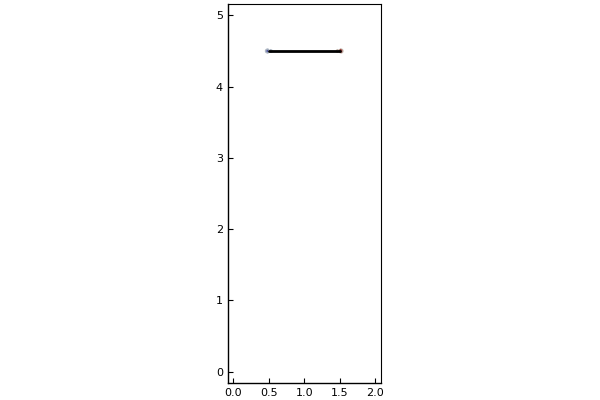

In [87]:
p = plot(xg,yg,whist[1],levels=contour_levels,color=:bluesreds)
for i = 1:bd.sys.nbody
    plot!(p,vshist[1][i,2:3,1], vshist[1][i,2:3,2],linewidth=2,linecolor="black")
end
p

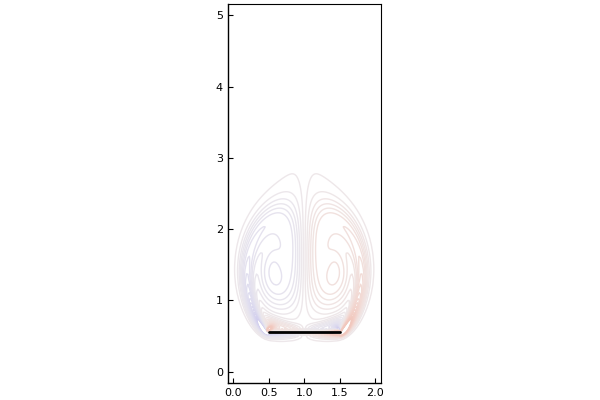

In [88]:
p = plot(xg,yg,whist[end],levels=contour_levels,color=:coolwarm)

for i = 1:bd.sys.nbody
    plot!(p,vshist[end][i,2:3,1], vshist[end][i,2:3,2],linewidth=2,linecolor="black")
end
# savefig(p,"plate.eps")
p

#### Body position begining and end

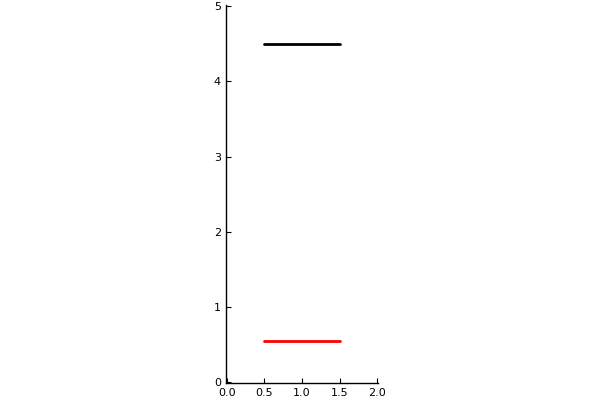

In [89]:
pb = plot()
for i = 1:sys.nbody
    plot!(pb,vshist[1][i,2:3,1], vshist[1][i,2:3,2],linewidth=2,linecolor="black",label="begin")
end
for i = 1:sys.nbody
    plot!(pb,vshist[end][i,2:3,1], vshist[end][i,2:3,2],linewidth=2,linecolor="red",label="end")
end
plot!(pb,xlims=(xg[1],xg[end]), ylims=(yg[1],yg[end]),ratio=1,legend=false)
pb

#### Make gif

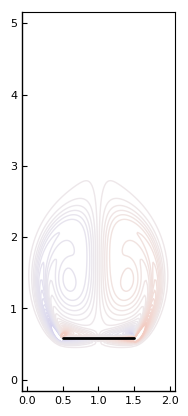

┌ Info: Saved animation to 
│   fn = /mnt/g/Research/FSI.jl/examples/FallingPlate.gif
└ @ Plots /home/fs/.julia/packages/Plots/oiirH/src/animation.jl:90


Plots.AnimatedGif("/mnt/g/Research/FSI.jl/examples/FallingPlate.gif")

In [90]:
anim = @animate for j = 1:sample_freq:length(whist)
    plot(xg,yg,whist[j],levels=contour_levels,color=:coolwarm)
    for i = 1:sys.nbody
        plot!(vshist[j][i,2:3,1], vshist[j][i,2:3,2],linewidth=2,linecolor="black")
    end
end

gif(anim, filename*".gif", fps = fps)

#### Get position, velocity and acceleration in time

In [91]:
vhist = [0.0]
phist = [0.0]

for i in 1:length(bdhist)
    push!(vhist,bdhist[i].bs[1].v[5])
    push!(phist,bdhist[i].bs[1].x_i[2]-bdhist[1].bs[1].x_i[2])    
end

ahist = []
for i in 1:length(vhist)-1
    push!(ahist,(vhist[i+1]-vhist[i])/Δt)
end

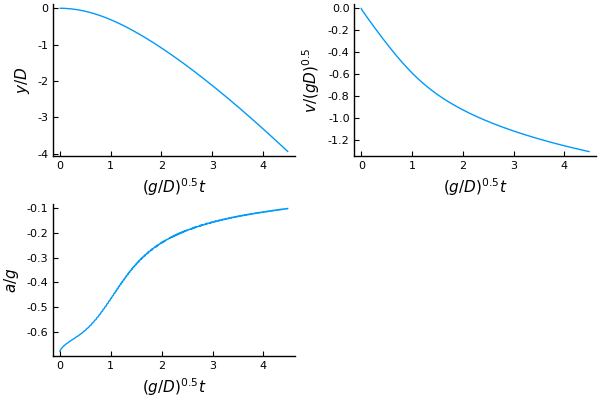

In [92]:
pp = plot([0.0;thist],phist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$y/D\$",legend=false)
pv = plot([0.0;thist],vhist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$v/(gD)^{0.5}\$",legend=false)
pa = plot([0.0;thist[1:end-1]],ahist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$a/g\$",legend=false)

plot(pp,pv,pa)

In [93]:
ahist[1:5]

5-element Array{Any,1}:
 -0.6796823428664687
 -0.675868059102475 
 -0.6725135159578011
 -0.6695126595623824
 -0.6667707252074103

#### Lift and drag coefficients

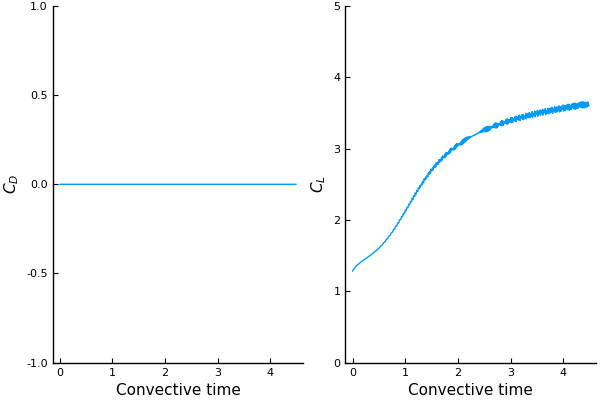

In [94]:
px = plot(thist,2*fx,ylim=(-1,1),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
py = plot(thist,2*fy,ylim=(0,5),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot(px,py)

## <span style="color:blue"> Save Data </span>

#### Save all current data related to plotting to a .jld file

In [95]:
@save filename*".bson" bd bdhist xg yg whist vshist thist fx fy Δt w qJ v t f

#### Use the following block to extract data

In [96]:
# using Dyn3d
# using ViscousFlow

# @load filename*".bson" bd bdhist xg yg whist vshist thist fx fy Δt w qJ v t f
# @get bd (bs,js,sys);